# Example notebook for the ATOM pipeline
---------------------------------

Download the Australian weather dataset from https://www.kaggle.com/jsphyg/weather-dataset-rattle-package.  
  
**Description:** Predict whether or not it will rain tomorrow by training a binary classification model on target RainTomorrow.

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

# Load the Australian weather dataset
X = pd.read_csv('weatherAUS.csv')
X = X.drop(['RISK_MM', 'Date'], axis=1)  # Drop unrelated features

In [2]:
# Call ATOM using only a percentage of the complete dataset (for explanatory purposes)
atom = ATOMClassifier(X, y="RainTomorrow", percentage=5, log='log', verbose=3, random_state=2)

<<=============== ATOM ===============>>
Initial data cleaning...
 --> Dropping 45 duplicate rows.
Algorithm task: binary classification.

Dataset stats ===================>
Shape: (7107, 22)
----------------------------------
Size of training set: 4974
Size of test set: 2133
----------------------------------
Instances in RainTomorrow per class:
        total  train_set  test_set
0: No    5554       3884      1670
1: Yes   1553       1090       463



In [3]:
# Impute missing values
atom.impute(strat_num='knn', strat_cat='missing', max_frac_rows=0.8)

Imputing missing values...
 --> Removing 762 rows for containing too many missing values.
 --> Imputing 7 missing values using the KNN imputer in feature MinTemp.
 --> Imputing 3 missing values using the KNN imputer in feature MaxTemp.
 --> Imputing 37 missing values using the KNN imputer in feature Rainfall.
 --> Imputing 2365 missing values using the KNN imputer in feature Evaporation.
 --> Imputing 2691 missing values using the KNN imputer in feature Sunshine.
 --> Imputing 187 missing values with missing in feature WindGustDir.
 --> Imputing 186 missing values using the KNN imputer in feature WindGustSpeed.
 --> Imputing 314 missing values with missing in feature WindDir9am.
 --> Imputing 41 missing values with missing in feature WindDir3pm.
 --> Imputing 4 missing values using the KNN imputer in feature WindSpeed9am.
 --> Imputing 2 missing values using the KNN imputer in feature WindSpeed3pm.
 --> Imputing 27 missing values using the KNN imputer in feature Humidity9am.
 --> Imput

In [4]:
# Encode the categorical features
atom.encode(max_onehot=10, frac_to_other=0.04)

Encoding categorical features...
 --> Target-encoding feature Location. Contains 1 unique categories.
 --> Target-encoding feature WindGustDir. Contains 17 unique categories.
 --> Target-encoding feature WindDir9am. Contains 17 unique categories.
 --> Target-encoding feature WindDir3pm. Contains 17 unique categories.
 --> One-hot-encoding feature RainToday. Contains 3 unique categories.


In [5]:
# Select only the best 10 features
atom.feature_selection(strategy="univariate", solver='f_classif', max_features=15, max_correlation=0.8)

# See which features were removed due to collinearity
atom.collinear

Performing feature selection...
 --> Feature Pressure3pm was removed due to collinearity with another feature.
 --> Feature Temp9am was removed due to collinearity with another feature.
 --> Feature Temp3pm was removed due to collinearity with another feature.
 --> Feature RainToday_Yes was removed due to collinearity with another feature.
 --> Feature Location was removed due to low variance: 0.00.
 --> Feature MinTemp was removed after the univariate test (score: 57.27  p-value: 0.00).
 --> Feature Evaporation was removed after the univariate test (score: 60.88  p-value: 0.00).
 --> Feature WindDir3pm was removed after the univariate test (score: 121.35  p-value: 0.00).
 --> Feature WindSpeed9am was removed after the univariate test (score: 49.85  p-value: 0.00).
 --> Feature WindSpeed3pm was removed after the univariate test (score: 40.73  p-value: 0.00).
 --> Feature Temp9am was removed after the univariate test (score: 0.44  p-value: 0.51).
 --> Feature RainToday_other was removed

,drop_feature,correlated_feature,correlation_value
0,Pressure3pm,Pressure9am,0.9601
1,Temp9am,"MinTemp, MaxTemp","0.90602, 0.88672"
2,Temp3pm,"MaxTemp, Temp9am","0.97441, 0.8497"
3,RainToday_Yes,RainToday_No,-0.98454


In [6]:
# Perform undersampling of the majority class to balance the dataset
atom.balance(undersample=0.8)

Using TensorFlow backend.


Performing undersampling...
 --> Removing 2529 rows from class No.


In [7]:
# Remove outliers from the training set
atom.outliers(max_sigma=5)

Handling outliers...
 --> Dropping 23 rows due to outliers.


In [8]:
# Change the verbosity of ATOM to not print too much details while fitting
atom.verbose = 2

# Let's compare the performance of the different gradient boosting algorithms
atom.fit(['gbm', 'lgb', 'catb'],
        metric='accuracy',  # You can use a custom metric as well
        max_iter=5,
        init_points=5,
        cv=1,
        bagging=5)


Running pipeline =================>
Models in pipeline: GBM, LGB, CatB
Metric: accuracy_score


Running BO for Gradient Boosting Machine...
Final results for Gradient Boosting Machine:         
Best hyperparameters: {'n_estimators': 500, 'learning_rate': 0.01, 'subsample': 1.0, 'max_depth': 10, 'max_features': 1.0, 'criterion': 'mse', 'min_samples_split': 2, 'min_samples_leaf': 20, 'ccp_alpha': 0.0}
Best score on the BO: 0.7854
Score on the training set: 0.9505
Score on the test set: 0.6718
Time elapsed: 25.63s
--------------------------------------------
Bagging score --> Mean: 0.6985   Std: 0.0118
Time elapsed: 39.77s


Running BO for LightGBM...
Final results for LightGBM:         
Best hyperparameters: {'n_estimators': 74, 'learning_rate': 0.68, 'max_depth': 3, 'num_leaves': 26, 'min_child_weight': 5, 'min_child_samples': 26, 'subsample': 0.9, 'colsample_bytree': 0.5, 'reg_alpha': 0.0, 'reg_lambda': 100.0}
Best score on the BO: 0.7978
Score on the training set: 0.8476
Score on the

### CatBoost proved to be the best. Let's have a look at the model!

In [9]:
print('Score on the training set: ', atom.CatB.score_train)
print('Score on the test set: ', atom.CatB.score_test)

Score on the training set:  0.815028901734104
Score on the test set:  0.7724288840262582


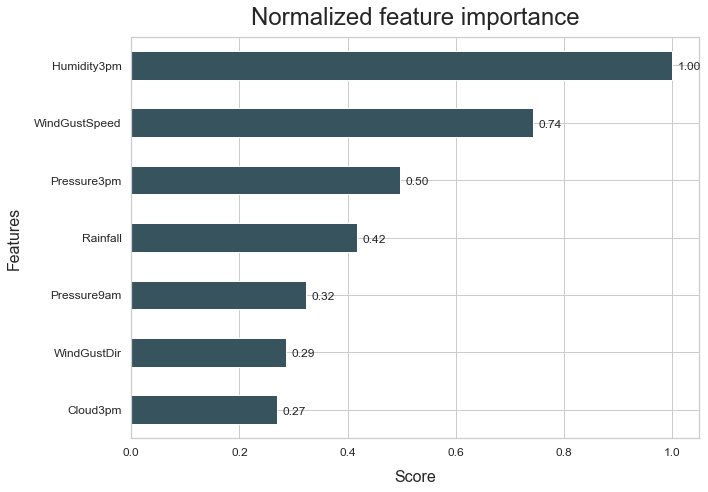

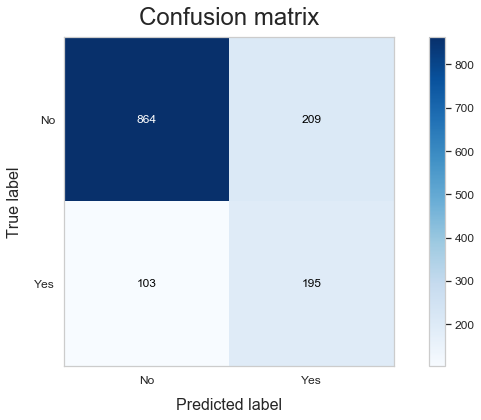

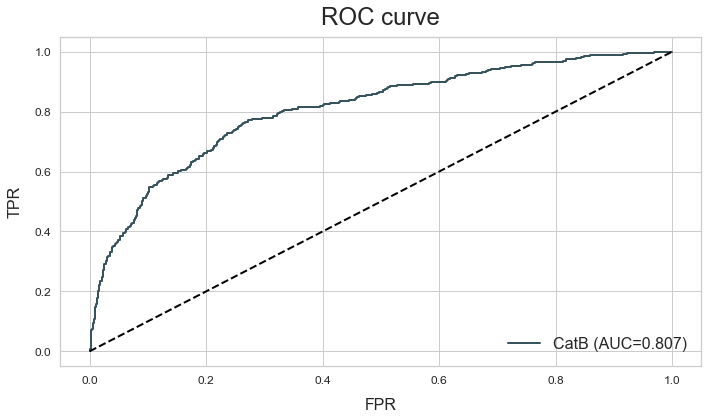

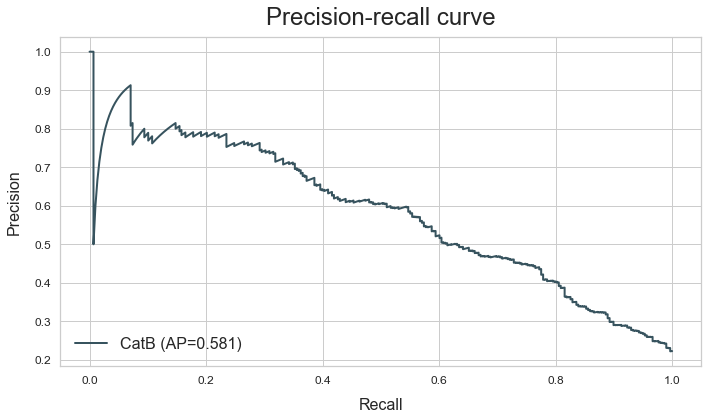

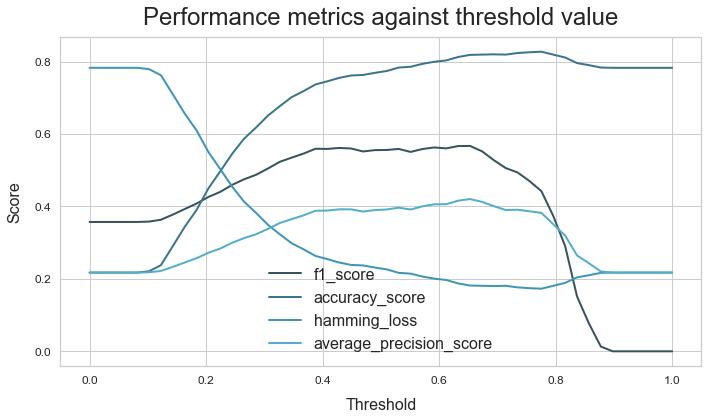

In [13]:
# Make some plots to analyze the results
atom.catb.plot_feature_importance(show=7, figsize=(10,7))
atom.catb.plot_confusion_matrix(normalize=False, filename='lgb_cm.png')

# Change plots aesthetics
ATOMClassifier.set_style('whitegrid')
ATOMClassifier.set_title_fontsize(24)

atom.catb.plot_ROC()
atom.catb.plot_PRC()
atom.catb.plot_threshold(metric=['f1', 'accuracy', 'hamming', 'ap'], steps=50)